# PyTorch Experiment Tracking

## What is experiment tracking?

Machine learning and deep learning are very experimental.

You have to put on your artist's beret/chef's hat to cook up lots of different models.

And you have to put on your scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where **experiment tracking** comes in.

If you're running lots of different experiments, **experiment tracking helps you figure out what works and what doesn't.**

## Different ways to track machine learning experiments

1. Python dictionaries, CSV files, print outs
2. Tensorboard - https://www.tensorflow.org/tensorboard/get_started
3. Weights & Biases Experiment Tracking - https://wandb.ai/site/experiment-tracking/
4. MLFlow - https://mlflow.org/

## 0. Getting Setup

In [21]:
# Import require lib
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import data_setup
from engine import train_step, test_step

from torch import nn
from torchvision import datasets
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype, Normalize
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


In [22]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [23]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get Data

In [24]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [25]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

 Since we can use the data_setup.py script for creating our datasets and dataloaders.

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [26]:
# Create a transforms pipeline manually 
manual_transforms = Compose([
    Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    ToImage(),
    ToDtype(dtype=torch.float32,scale=True),
    Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
             std=[0.229, 0.224, 0.225]), # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
manual_transforms

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [27]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x30c4d5300>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

As previously stated, when using a pretrained model, it's important that ***your custom data going into the model is prepared in the same way as the original training data that went into the model***.

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```
See more details here - https://docs.pytorch.org/vision/stable/models.html
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html?highlight=efficientnet_b0_weights#torchvision.models.EfficientNet_B0_Weights

In [28]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [29]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## 3. Getting a pretrained model

Our models haven't been performing as well as we'd like.That's where **transfer learning** comes in.
The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customise it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in `torchvision.models`.

Models are : 
1. ResNet - torchvision.models.resnet18(), torchvision.models.resnet50(),...
2. VGG (similar to what we used for TinyVGG) - torchvision.models.vgg16(), ...
3. EfficientNet - torchvision.models.efficientnet_b0(), torchvision.models.efficientnet_b1(), ...
4. VisionTransformer (ViT's) - torchvision.models.vit_b_16(), torchvision.models.vit_b_32()...
5. ConvNeXt - torchvision.models.convnext_tiny(), torchvision.models.convnext_small()...

More details : https://pytorch.org/vision/stable/models.html

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()`) means better performance but a larger model.

You might think better performance is always better, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [The Bitter Lesson states](http://www.incompleteideas.net/IncIdeas/BitterLesson.html), you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

### 3.2 Setting up a pretrained model
The pretrained model we're going to be using is `torchvision.models.efficientnet_b0()`. - https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/

In [30]:
# Setup the model with pretrained weights 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 

# Setup the model with pretrained weights and send it to device 
#model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# in my case i will use cpu
model = torchvision.models.efficientnet_b0(weights=weights)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [31]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

Our problem is classifying 3 different food items but the pretrained model we're using was trained on 1000 different classes of images.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [32]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )

  And we'll keep in_features=1280 for our `Linear` output layer but we'll change the out_features value to the length of our `class_names (len(['pizza', 'steak', 'sushi']) = 3)`.

In [33]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [34]:
# View the summary after freezing
summary(model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

In [35]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Adjust `train()` function to track results with `SummaryWriter()`

In [36]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [37]:
from typing import Dict, List
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [38]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device="cuda" if torch.cuda.is_available() else "cpu")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/aungsan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0963 | train_acc: 0.3984 | test_loss: 0.8989 | test_acc: 0.5597
Epoch: 2 | train_loss: 0.8907 | train_acc: 0.6328 | test_loss: 0.7969 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7568 | train_acc: 0.8555 | test_loss: 0.7469 | test_acc: 0.7538
Epoch: 4 | train_loss: 0.7724 | train_acc: 0.7109 | test_loss: 0.6958 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6326 | train_acc: 0.9023 | test_loss: 0.6319 | test_acc: 0.8864
[INFO] Total training time: 442.151 seconds


## 5. View our model's results in TensorBoard

The SummaryWriter() class stores our model's results in a directory called runs/ in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

1. in your vscode - https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration
2. Jupyter and Colab Notebooks - `torch.utils.tensorboard` or https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [39]:
results

{'train_loss': [1.0963450521230698,
  0.8906637206673622,
  0.756829522550106,
  0.7724450528621674,
  0.6325657591223717],
 'train_acc': [0.3984375, 0.6328125, 0.85546875, 0.7109375, 0.90234375],
 'test_loss': [0.8988541563351949,
  0.7969464858373007,
  0.7468806505203247,
  0.6957987348238627,
  0.6319160858790079],
 'test_acc': [0.5596590909090909,
  0.7945075757575758,
  0.7537878787878788,
  0.8248106060606061,
  0.8863636363636364]}

In [40]:
# Example code to run in Jupyter or Google Colab Notebook 
%load_ext tensorboard
%tensorboard --logdir runs

## 6. Create a helper function to build `SummaryWriter()` instances
The SummaryWriter() class logs various information to a directory specified by the log_dir parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:

Experiment date/timestamp - when did the experiment take place?
Experiment name - is there something we'd like to call the experiment?
Model name - what model was used?
Extra - should anything else be tracked?

In [41]:
from torch.utils.tensorboard.writer import SummaryWriter

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [42]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_10_percent/effnetb0/5_epochs...


### 6.1 Update the `train()` function to include a `writer` parameter

In [43]:
from typing import Dict, List
from tqdm.auto import tqdm


# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

Previously we've been running various experiments and inspecting the results one by one.

But what if we could run multiple experiments and then inspect the results all together?

### 7.1 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This is where you'll have to put on your scientist coat and remember the machine learning practitioner's motto: experiment, experiment, experiment!

Every hyperparameter stands as a starting point for a different experiment:

* Change the number of epochs.
* Change the number of layers/hidden units.
* Change the amount of data.
* Change the learning rate.
* Try different kinds of data augmentation.
* Choose a different model architecture.

### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

We've got plenty of options but how about we keep things simple?

Let's try a combination of:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get:

|Experiment number |	Training Dataset|	Model (pretrained on ImageNet)|	Number of epochs|
|------------------| -------------------|---------------------------------|-----------------|
|1|	Pizza, Steak, Sushi 10% percent|	EfficientNetB0|	5|
|2|	Pizza, Steak, Sushi 10% percent|	EfficientNetB2|	5|
|3|	Pizza, Steak, Sushi 10% percent|	EfficientNetB0|	10|
|4|	Pizza, Steak, Sushi 10% percent|	EfficientNetB2|	10|
|5|	Pizza, Steak, Sushi 20% percent|	EfficientNetB0|	5|
|6|	Pizza, Steak, Sushi 20% percent|	EfficientNetB2|	5|
|7|	Pizza, Steak, Sushi 20% percent|	EfficientNetB0|	10|
|8|	Pizza, Steak, Sushi 20% percent|	EfficientNetB2|	10|

### 7.3 Download different datasets

We'll need two forms of a training set:

1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

In [44]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [45]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoaders

In [46]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = Compose([
    Resize((224, 224)), # 1. Resize the images
    ToImage(),
    ToDtype(torch.float32, scale=True), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [47]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models
We're going to create two feature extractor models:

1. `torchvision.models.efficientnet_b0()` pretrained backbone + custom classifier head (EffNetB0 for short).
2. `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head (EffNetB2 for short).

In [48]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


We want these functions to:

1. Get the base model from torchvision.models
2. Freeze the base layers in the model (set requires_grad=False)
3. Set the random seeds (we don't need to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)

In [49]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)
OUT_FEATURES

3

In [50]:
# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    complied_model = torch.compile(model)
    # 2. Freeze the base model layers
    for param in complied_model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [51]:
effnetb0 = create_effnetb0() 

#Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [52]:
# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    complied_model = torch.compile(model)
    # 2. Freeze the base model layers
    for param in complied_model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [53]:
effnetb02 = create_effnetb2() 

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb02, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code

We'll start by creating two lists and a dictionary:

1. A list of the number of epochs we'd like to test ([5, 10])
2. A list of the models we'd like to test (["effnetb0", "effnetb2"])
3. A dictionary of the different training DataLoaders

In [54]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [55]:
from save import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/aungsan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352
Epoch: 6 | train_loss: 0.5720 | train_acc: 0.9023 | test_loss: 0.5509 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5508 | train_acc: 0.7969 | test_loss: 0.5324 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5074 | train_acc: 0.8164 | test_loss: 0.5141 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5785 | train_acc: 0.7891 | test_loss: 0.5324 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4566 | train_acc: 0.8281 | test_loss: 0.4553 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.6171 | train_acc: 0.8047 | test_loss: 0.6172 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.5571 | train_acc: 0.8047 | test_loss: 0.6235 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5715 | train_acc: 0.7852 | test_loss: 0.5641 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.4797 | train_acc: 0.9180 | test_loss: 0.5521 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5223 | train_acc: 0.8164 | test_loss: 0.5839 | test_acc: 0.8466
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-09-17/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3830 | train_acc: 0.8979 | test_loss: 0.3499 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.4221 | train_acc: 0.8396 | test_loss: 0.3273 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3339 | train_acc: 0.9229 | test_loss: 0.3407 | test_acc: 0.9186
Epoch: 9 | train_loss: 0.3152 | train_acc: 0.9229 | test_loss: 0.2938 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3174 | train_acc: 0.8854 | test_loss: 0.3051 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4618 | train_acc: 0.8396 | test_loss: 0.4609 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3966 | train_acc: 0.8625 | test_loss: 0.4777 | test_acc: 0.8570
Epoch: 8 | train_loss: 0.3433 | train_acc: 0.9187 | test_loss: 0.4021 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3418 | train_acc: 0.9125 | test_loss: 0.4112 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3285 | train_acc: 0.8854 | test_loss: 0.4145 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in TensorBoard

In [59]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24975), started 1:45:36 ago. (Use '!kill 24975' to kill it.)

## 9. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:

* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

Let's visualize, visualize, visualize!

In [61]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

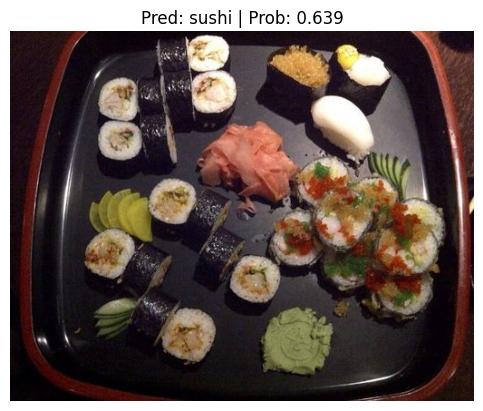

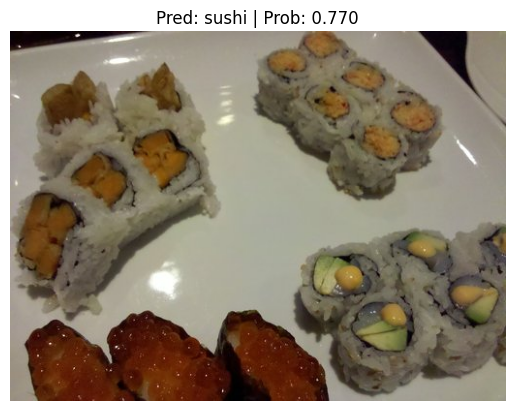

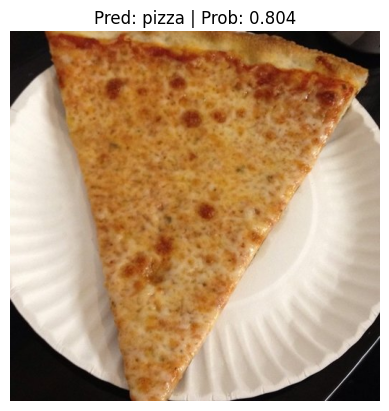

In [63]:
# Import function to make predictions on images and plot them 
from predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))